## Data and Package Importing

In [1]:
from QC import *
from ml_utils import *
sc.settings.set_figure_params(dpi=80)

In [ ]:
# reload fcc module while working
import sys
del sys.modules['ml_utils']
from ml_utils import *

### Load data and preprocess

Read in normal human colon sample

In [2]:
%time s1 = sc.read('3247-AS-1-GCCAAT_S1_counts.tsv.gz')

CPU times: user 1min 12s, sys: 1.27 s, total: 1min 13s
Wall time: 1min 13s


In [3]:
%%time
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(s1)

# create new "observations" as percent and mean mito genes
s1.var['mito'] = s1.var_names.str.contains('MT-') # identify mitochondrial genes
s1.obs['mean_mito'] = np.mean(s1[:,s1.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(s1, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var

# rank cells by total counts and save as .obs
s1.obs['ranked_total_counts'] = np.argsort(s1.obs['total_counts'])

CPU times: user 7.44 s, sys: 2.23 s, total: 9.67 s
Wall time: 9.67 s


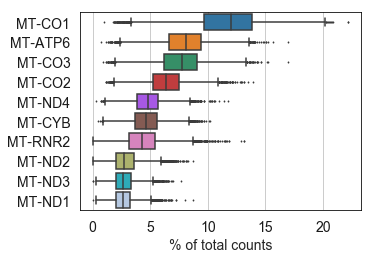

In [4]:
# look at highest expression by gene across all cells
sc.pl.highest_expr_genes(s1, n_top=10)

Looks like a lot of dead cells (high mitochondrial counts).

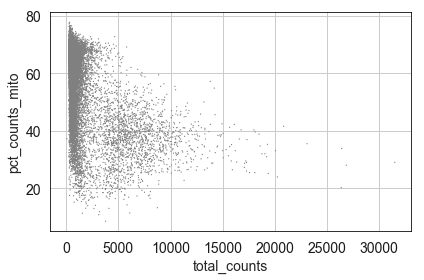

In [5]:
# look at low-quality and dead cell distribution
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito')

### Find inflection point

Inflection point at bcEGRW     3541
bcIJCL     2348
bcBEDN     7392
bcEFCU    10593
bcGJKY    13918
bcDZKU    19127
Name: total_counts, dtype: int64 for [0, 15, 30, 50, 70, 100] percentiles of greatest secant distances


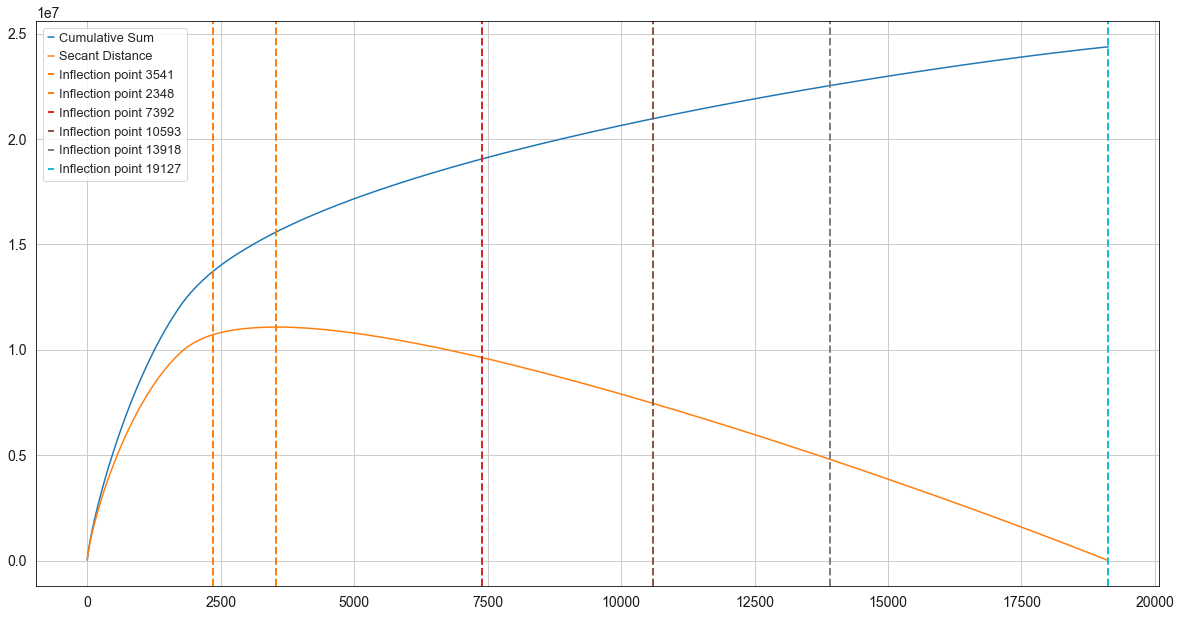

In [7]:
find_inflection(s1, inflection_percentiles = [0,15,30,50,70,100])

In [10]:
s1.obs['total_counts'][13918] # see the total counts for the cutoff point

424.0

Cutoff for `emptyDrops` should be at the number of counts above. We should be pretty conservative here because we don't want to mix **'dead'** and **'empty'** labels.   
`emptyDrops.r` script can be run from command line using:  
```
Rscript emptyDrops.r 3247-AS-1-GCCAAT_S1_counts.tsv.gz -cxg -l 424 -o 3247-AS-1-GCCAAT_S1_emptydrops.csv -rn 'barcode'
```
Let's read in  `emptyDrops` predictions and filter out empty droplets, then ID dead cells.

In [18]:
emptydrops = pd.read_csv('3247-AS-1-GCCAAT_S1_emptydrops.csv')
# create new "observation" as empty droplet label
s1.obs['label'] = np.where(emptydrops['empty']==1, 'empty', '')

In [24]:
# keep only cells not identified as empty by emptydrops
s1_notempty = s1[s1.obs['label']=='',:].copy()

### Normalize and perform linear dimensionality reduction with PCA

In [25]:
%%time
sc.pp.normalize_total(s1_notempty, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1_notempty) # log1p transformation
sc.pp.scale(s1_notempty, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 1.56 s, sys: 227 ms, total: 1.79 s
Wall time: 1.79 s


In [26]:
# checkpoint normalized and scaled data for future visualizations
s1_notempty.raw = s1_notempty

... storing 'label' as categorical


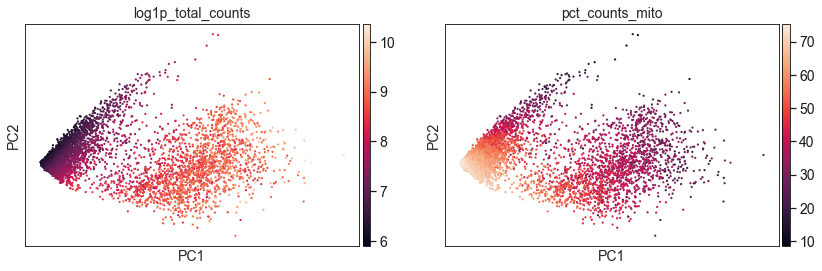

CPU times: user 42.1 s, sys: 2.75 s, total: 44.9 s
Wall time: 7.63 s


In [27]:
%%time
sc.tl.pca(s1_notempty, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1_notempty, color=['log1p_total_counts','pct_counts_mito'], ncols=2)

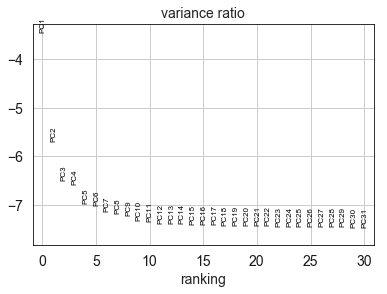

In [29]:
sc.pl.pca_variance_ratio(s1_notempty, log=True) #examine amount of variance captured by each principal component

### Non-linear dimensionality reduction with UMAP

In [31]:
%%time
sc.pp.neighbors(s1_notempty, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.umap(s1_notempty, random_state=1) # perform UMAP

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:7

CPU times: user 15.6 s, sys: 505 ms, total: 16.1 s
Wall time: 14 s


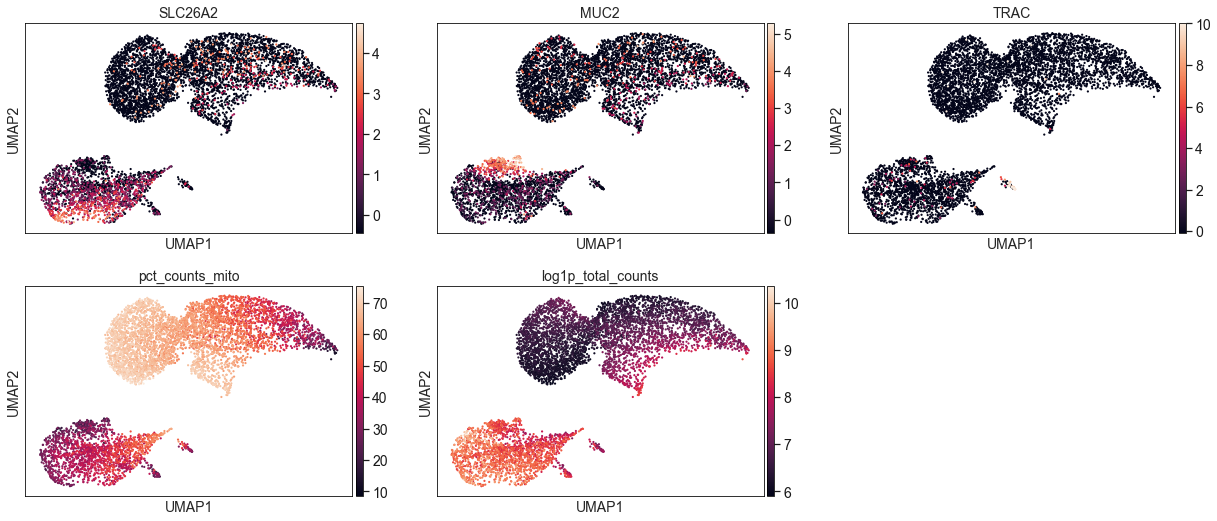

In [32]:
sc.pl.umap(s1_notempty, color=['SLC26A2','MUC2','TRAC','pct_counts_mito','log1p_total_counts'], ncols=3) # plot marker genes to determine which clusters to keep or gate out

### Clustering

In [33]:
sc.tl.louvain(s1_notempty, resolution=1, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

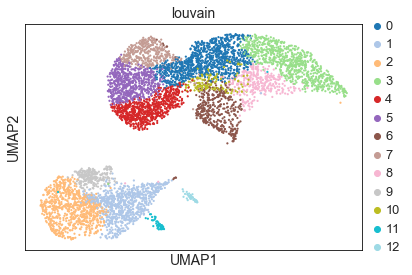

In [34]:
sc.pl.umap(s1_notempty, color=['louvain'], palette='tab20')

### Cluster quantification and non-parametric testing of gene expression profiles for gating

In [35]:
%time cluster_summary_stats(s1_notempty, raw=False) # in this case it's after normalization, but if you want to find these statistics for the raw counts, set the raw parameter to True

CPU times: user 4.74 s, sys: 2.35 s, total: 7.09 s
Wall time: 7.09 s


In [36]:
cluster_wilcoxon_rank_sum(s1_notempty, ['SLC26A2','MUC2','TRAC','pct_counts_mito','log1p_total_counts'], alternative='greater') 
#this takes a list of features that exist in the normalized representation of the data and performs a wilcoxon rank sum test between each cluster against the global counterparts of those data.
#these features can be single genes or compiled 'metagenes' such as the percent_mito and the mean_mito, as long as their values can be accessed in the AnnData object by using the .obs_vector method
#the "alternative" parameter is passed to scipy's "mann-whitney u" to designate the sidedness of the test, in this case the default is a one-sided hypothesis for values greater than the null.

In [37]:
cluster_p_threshold(s1_notempty, 0.05)
#this takes the p-values calculated above (per cluster) and simply returns a binarized output (0 or 1) that can be visualized
#the output represents wether or not the cluster has a p-value below the set threshold (0.05 in this case) 

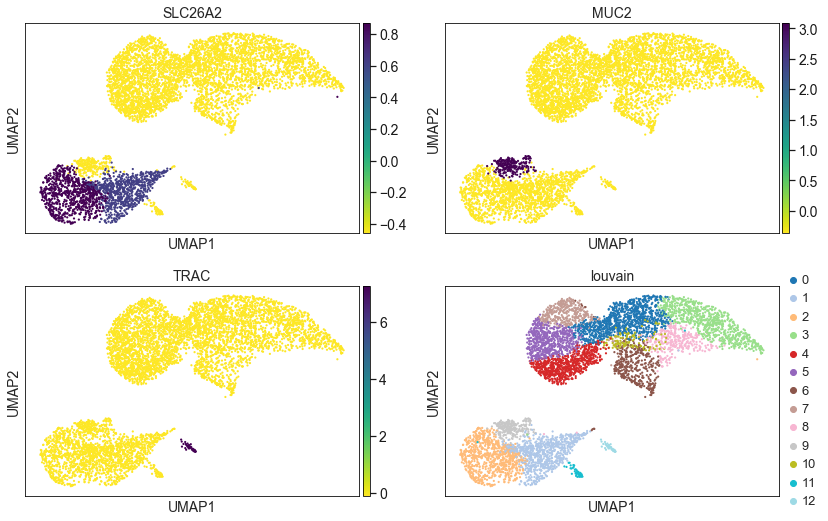

In [38]:
sc.pl.umap(s1_notempty, color=['SLC26A2','MUC2','TRAC','louvain'], color_map='viridis_r', layer='Cluster_Medians', ncols=2) 
# cluster medians per feature

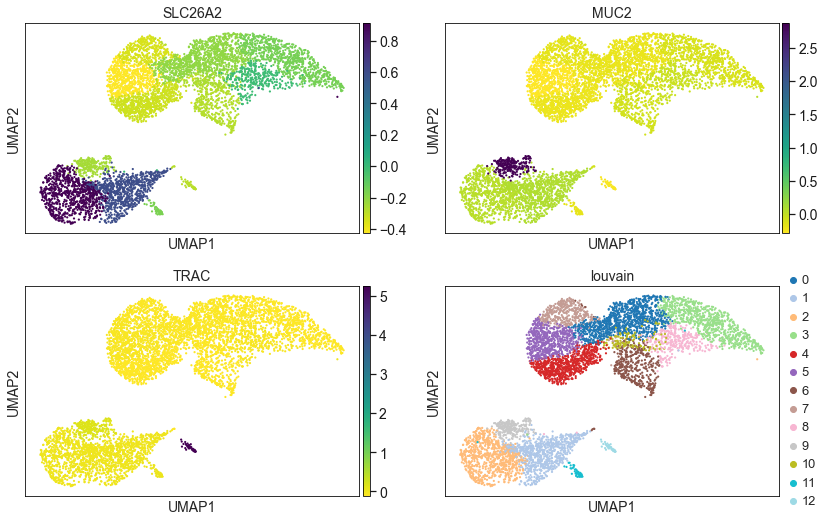

In [39]:
sc.pl.umap(s1_notempty, color=['SLC26A2','MUC2','TRAC','louvain'], color_map='viridis_r', layer='Cluster_Means', ncols=2) 
# cluster means per feature

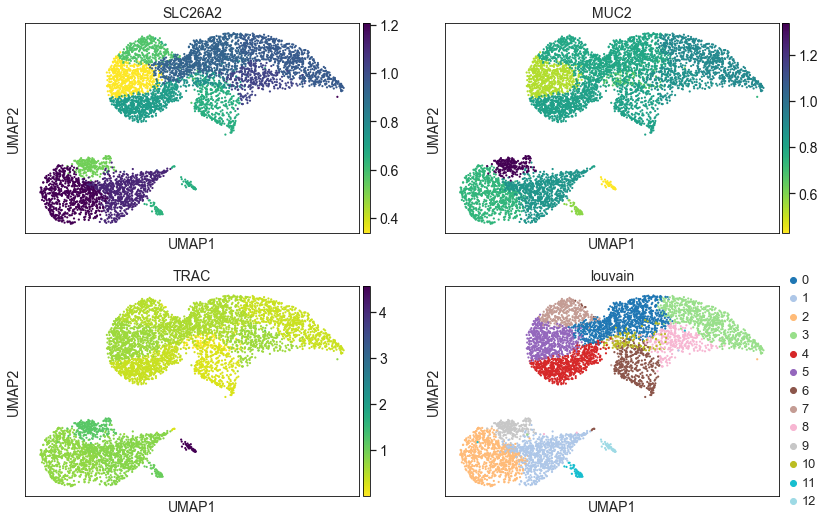

In [40]:
sc.pl.umap(s1_notempty, color=['SLC26A2','MUC2','TRAC','louvain'], color_map='viridis_r', layer='Cluster_Stdevs', ncols=2) 
# cluster stdevs per feature

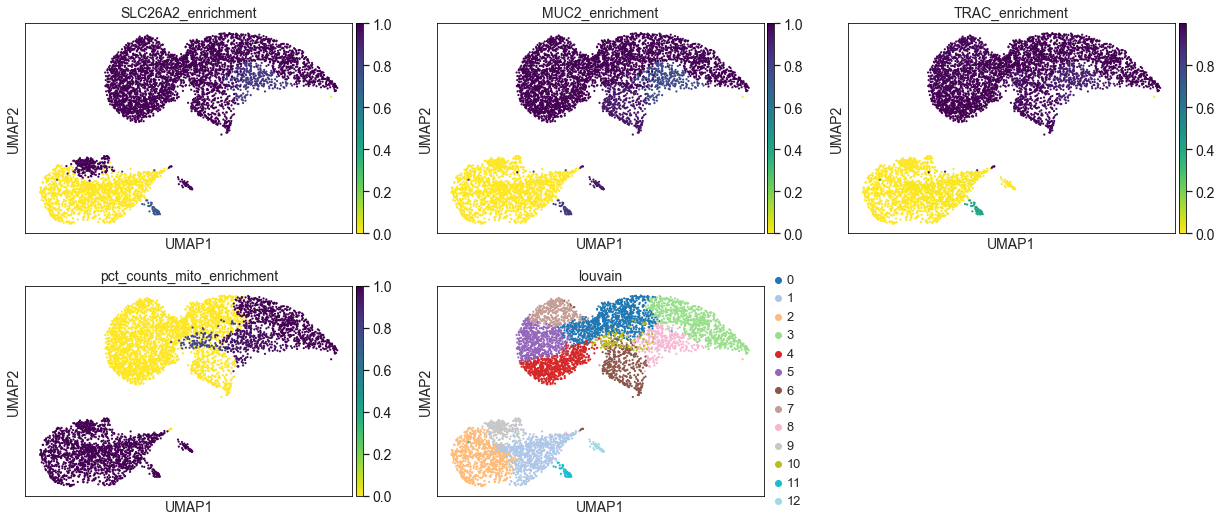

In [42]:
sc.pl.umap(s1_notempty, color=['SLC26A2_enrichment','MUC2_enrichment','TRAC_enrichment','pct_counts_mito_enrichment','louvain'], color_map='viridis_r', ncols=3)
# these are simply the p-values resulting from the features/featuresets tested, this visualization just shows a continuum of p-values per cluster given that test

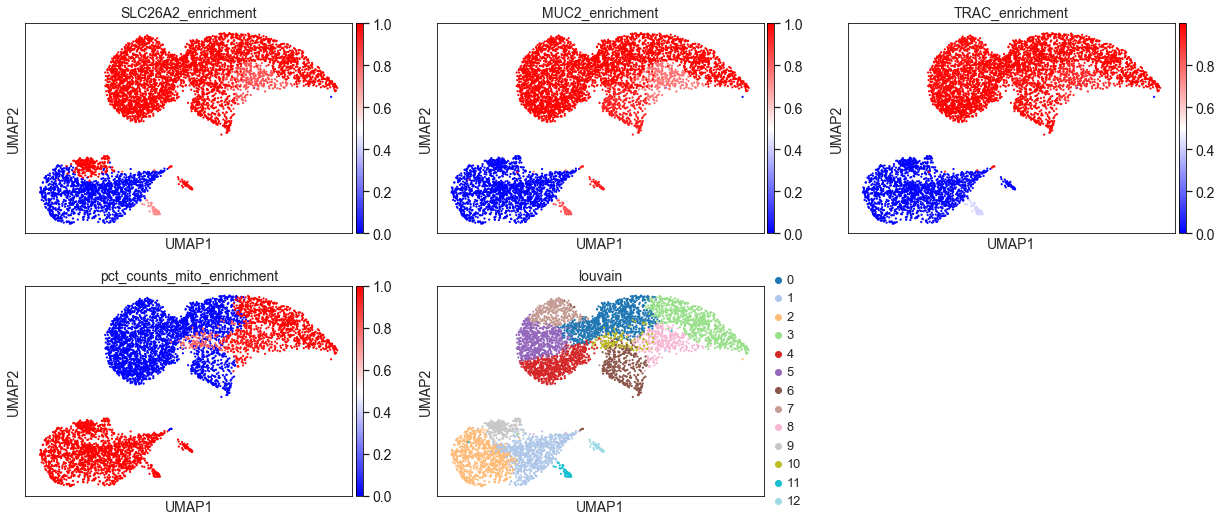

In [43]:
sc.pl.umap(s1_notempty, color=['SLC26A2_enrichment','MUC2_enrichment','TRAC_enrichment','pct_counts_mito_enrichment','louvain'], color_map = 'bwr', ncols=3)
# similar to above, but with significance threholded at 0.05 as per the example, this gives us a better idea of which louvain clusters to gate out based off of statistical bases

The above overlays are simply to guide the louvain cluster gating process by providing more quantitative and statistically robust methods for determining which clusters to gate out  

In [48]:
to_keep = np.where(s1_notempty.obs['louvain'].isin(['1','2','9','11','12']))[0] # fill in the indices of the clusters you want to keep here
# we choose these to keep because all other clusters have a significant enrichment for mitochondrial genes or hematopoetic cells

In [49]:
filtered = s1[to_keep,:].copy() # subsetting the original data to make a filtered dataset, here, we subset the raw (.raw) count data for our new object/QC'd dataset

In [50]:
filtered

AnnData object with n_obs × n_vars = 1902 × 41569 
    obs: 'mean_mito', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'empty', 'label'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

... storing 'label' as categorical


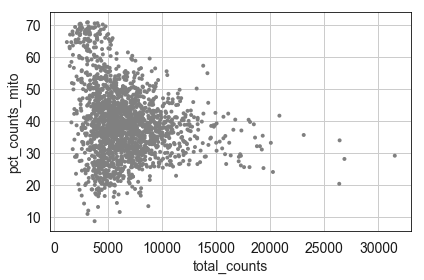

In [53]:
# look at low-quality and dead cell distribution
sc.pl.scatter(filtered, x='total_counts', y='pct_counts_mito')

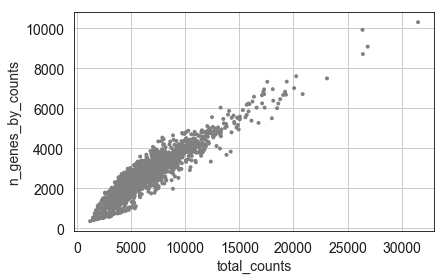

In [54]:
sc.pl.scatter(filtered, x='total_counts', y='n_genes_by_counts')

### Find inflection point

Inflection point at bcFRPQ     790
bcIBFJ     932
bcAVLO    1081
bcEUNE    1290
bcEGSD     184
bcDZKU    1901
Name: total_counts, dtype: int64 for [0, 15, 30, 50, 70, 100] percentiles of greatest secant distances


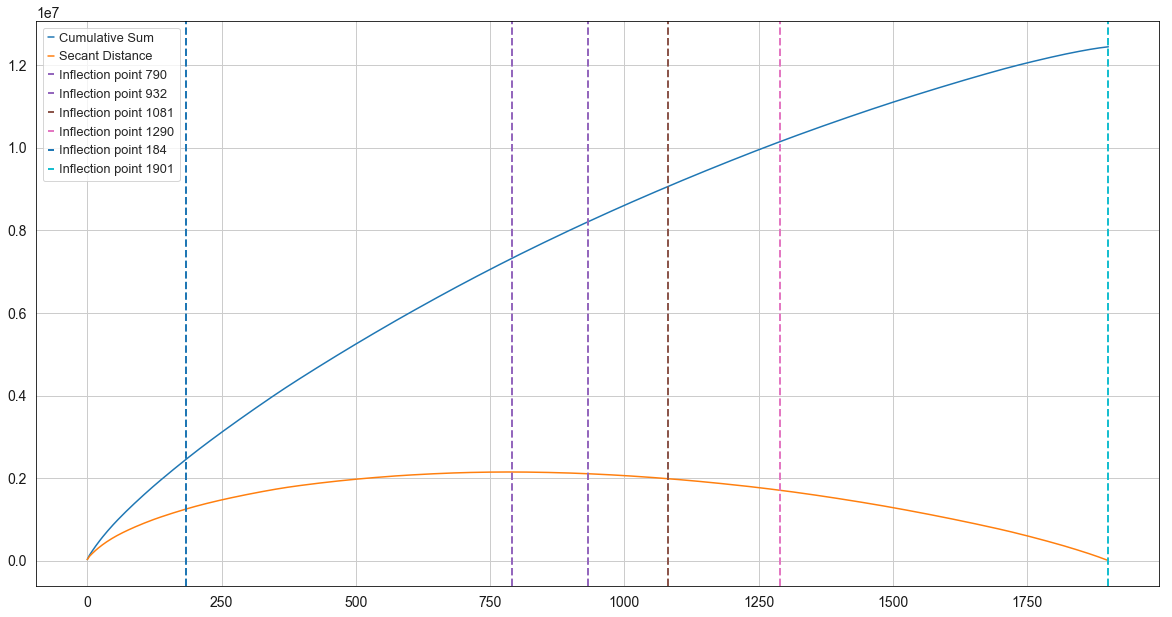

In [55]:
find_inflection(filtered, inflection_percentiles = [0,15,30,50,70,100])

In [56]:
filtered.obs['total_counts'][1901] # see the total counts for the cutoff point

1201.0

### Normalize and perform linear dimensionality reduction with PCA

In [57]:
%%time
sc.pp.normalize_total(filtered, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(filtered) # log1p transformation
sc.pp.scale(filtered, max_value=10)

CPU times: user 494 ms, sys: 16.9 ms, total: 511 ms
Wall time: 510 ms


In [58]:
# checkpoint normalized and scaled data for future visualizations
filtered.raw = filtered

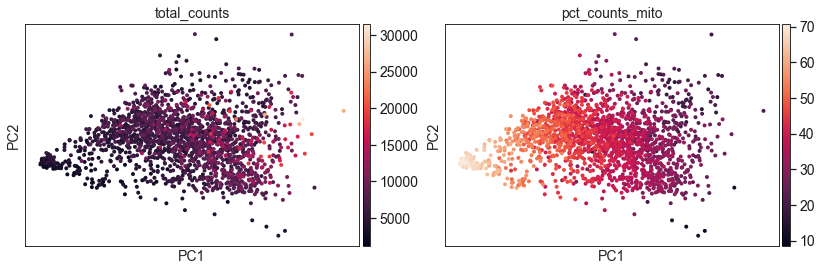

CPU times: user 19.3 s, sys: 2.06 s, total: 21.4 s
Wall time: 2.76 s


In [59]:
%%time
sc.tl.pca(filtered, n_comps=100) # perform PCA and plot results
sc.pl.pca(filtered, color=['total_counts','pct_counts_mito'], ncols=2)

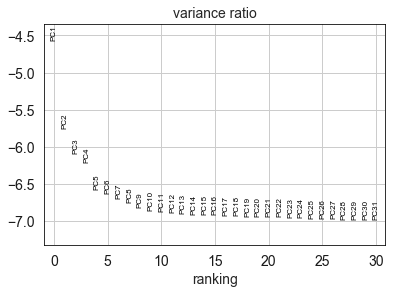

In [60]:
sc.pl.pca_variance_ratio(filtered, log=True) #examine amount of variance captured by each principal component

### Non-linear dimensionality reduction with UMAP

In [61]:
%%time
sc.pp.neighbors(filtered, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.umap(filtered, random_state=1) # perform UMAP

CPU times: user 3.69 s, sys: 133 ms, total: 3.83 s
Wall time: 2.88 s


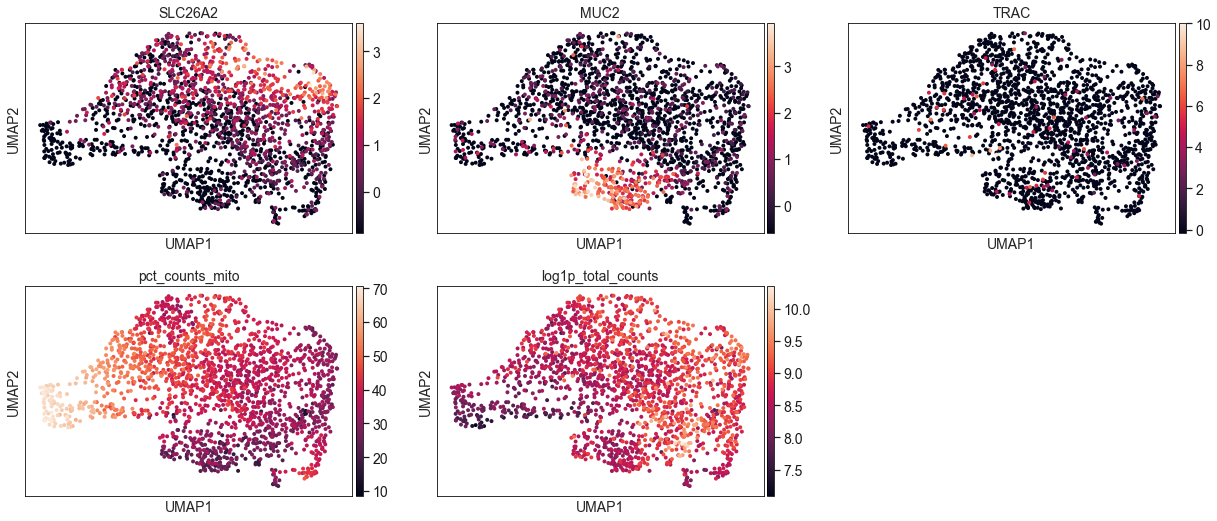

In [62]:
sc.pl.umap(filtered, color=['SLC26A2','MUC2','TRAC','pct_counts_mito','log1p_total_counts'], ncols=3, use_raw=False) # plot marker genes to determine which clusters to keep or gate out

Now finish adding labels to AnnData object

In [67]:
s1.obs.loc[s1.obs.index[to_keep], 'label'] = 'live'

In [69]:
s1.obs.loc[s1.obs['label']=='', 'label'] = 'dead'

In [73]:
s1.obs['label'].value_counts()

empty    12805
dead      4421
live      1902
Name: label, dtype: int64

In [74]:
s1.write_h5ad('3247-AS-1-GCCAAT_S1_labeled.h5ad',compression='gzip') # optional saving results to file as compressed .h5ad 

... storing 'label' as categorical


---
### Machine Learning Classifiers

In [79]:
%%time
sc.pp.normalize_total(s1, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) # log1p normalization
sc.pp.scale(s1, max_value=10) # scaling by variance and centering to zero for visualization
sc.tl.pca(s1, n_comps=100) # perform PCA

CPU times: user 1min 51s, sys: 5.56 s, total: 1min 57s
Wall time: 24.2 s


Test using wrapper function from `ml_utils.py`

In [80]:
s1.obs['label'].unique() # order of labels for plots

[live, dead, empty]
Categories (3, object): [live, dead, empty]

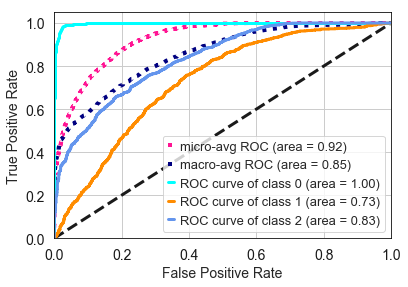

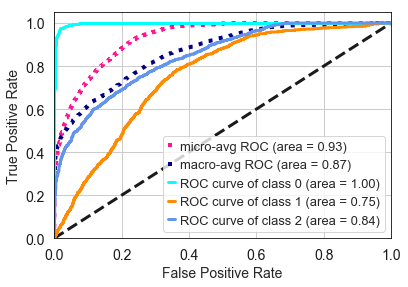

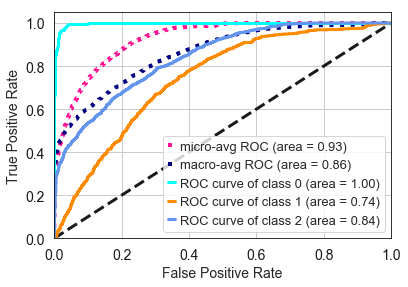

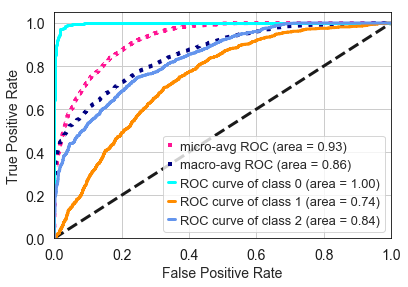

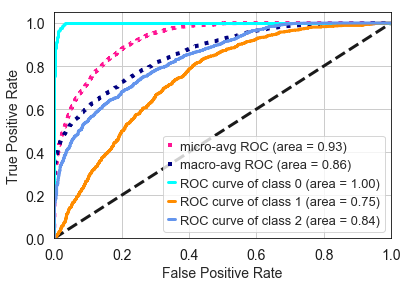

CPU times: user 3min 31s, sys: 14 s, total: 3min 45s
Wall time: 38.3 s


In [81]:
%%time
# Logistic Regression Classifier
lr = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial', max_iter=1000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

for train, test in cv.split(s1.obsm['X_pca'], s1.obs['label']):
    mets = multiclass_roc(clf=lr, X_train=s1.obsm['X_pca'][train], X_test=s1.obsm['X_pca'][test], y_train=s1.obs['label'][train], y_test=s1.obs['label'][test])

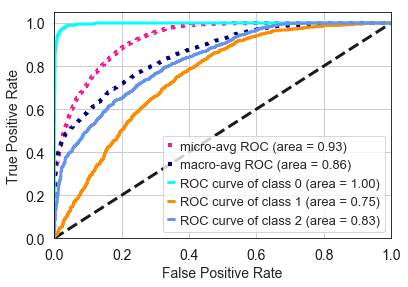

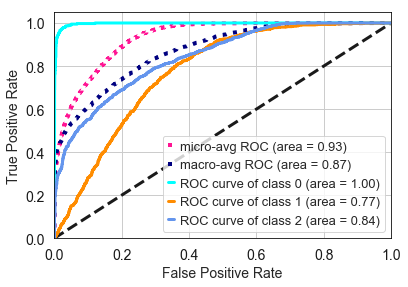

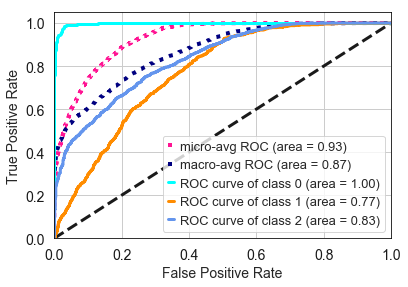

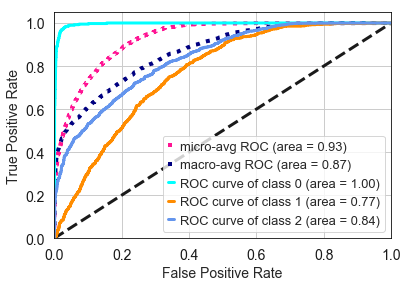

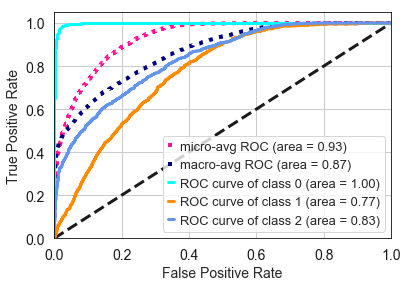

CPU times: user 2min 58s, sys: 687 ms, total: 2min 59s
Wall time: 3min


In [82]:
%%time
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()

for train, test in cv.split(s1.obsm['X_pca'], s1.obs['label']):
    mets = multiclass_roc(clf=gbc, X_train=s1.obsm['X_pca'][train], X_test=s1.obsm['X_pca'][test], y_train=s1.obs['label'][train], y_test=s1.obs['label'][test])

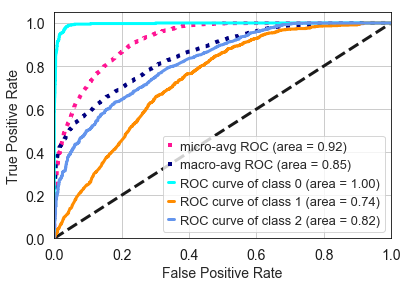

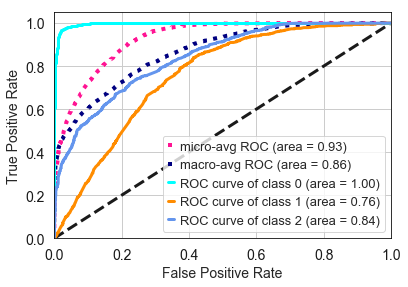

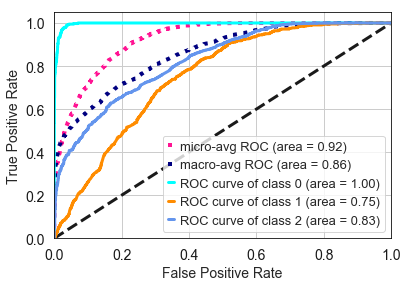

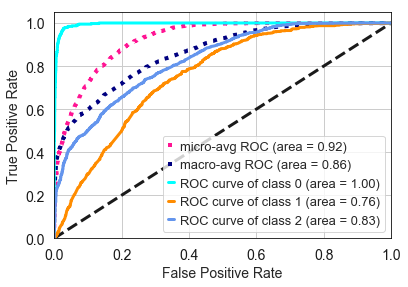

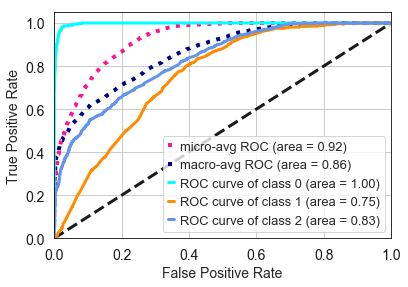

CPU times: user 1min 48s, sys: 469 ms, total: 1min 48s
Wall time: 1min 47s


In [83]:
%%time
# AdaBoost Classifier
abc = AdaBoostClassifier()

for train, test in cv.split(s1.obsm['X_pca'], s1.obs['label']):
    mets = multiclass_roc(clf=abc, X_train=s1.obsm['X_pca'][train], X_test=s1.obsm['X_pca'][test], y_train=s1.obs['label'][train], y_test=s1.obs['label'][test])